In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dataset-characters-indo-plate:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1474962%2F2573942%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T140613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9952c29609d413bfa8b2defa64824d8ede20c302659743e3e8e52eecc823b31cae94798029a2063d8f9842e0c7c75c27bb4fe341193b48f858b640160d4efe279f37ed83ba8f02fd4a3f726de0b72d5639698572b5ebc34dc79a83a702e4fa0230742182669736abefbc7f478b3108b6d278c5c900f3c4693fbd3f6fa704a20f9cade2e437bfb52a0597a18b4fff5ff316cd165f29dd3984395e040cb1584b7dd64a7c0bf8c4a04d728e312ef8ca39a3b95a7dd2b401d352610ebc5a00d3a902ed362bb32684236b673179b53dfbccb398836d6c9a55cffe4990b27aea44d54107e47dcae191ff6016f8296028e85fcbce0b515fad347e908f7da0b68018f5af,haarcascadeplatenumber:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3091319%2F5395040%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T140613Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D33903b4bd5970d7a56251ff768ee6da2e2359023c089a6f38a2580b2d14761d416accebad67b84b70b345d2eacb11d01f8403317ba92899212c82c383ec5dd030f33fb93086136ad9c42ae0c8c4d4c931ab4f54692de9b76f50d18ace5afd69084dc5d57b737cc657dea623bd8e467e84c99b64b820b9f6d7f1159ba98a4161bd31deb31ac9f246f993ca947660bc038e00e8a4cc4378e52f97d843d45ccbc9d8f2a5baa1d0e3e70c1e15078f3e6e14b77f485124c584ef2632e63bd28c5f2b03883773eda7abc9d5f0888d2143d110bc4260edc217a5acc27805b736c1c564d33e589ddbf1392232b6526b8e5ee63f148ef18e050ddf06a4e7d8639f3325016'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 38140492 bytes downloaded
Downloaded and uncompressed: dataset-characters-indo-plate
[==================================================] 1121949378 bytes downloaded
Downloaded and uncompressed: haarcascadeplatenumber
Data source import complete.


## TR PDNN 2023
diadaptasi dari: https://github.com/img88/ALPR_IndonesiaPlateNumber_ComputerVision

In [3]:
#  ! pip install imutils -q

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
# import imutils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from skimage import io
import urllib.request

from datetime import datetime
import uuid


def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()



# FULL PROGRAM BELOW
> Program dibawah ini digunakan untuk menghasilkan dataset karakter dari poto plat motor yang telah diambil. setelah program menghasilkan karakter plat, perlu dilakukan `zip` secara manual untuk mendownload hasilnya.

In [ ]:
# gunakan cell ini untuk mendownload dataset yang telah dihasilkan
! ls @*

ls: cannot access '@*': No such file or directory


In [4]:
indeximg=0
filepath=[]
for root, dirname, filename in os.walk('/kaggle/input/haarcascadeplatenumber'):
    for file in filename:
        filepath.append(os.path.join(root, file))

In [5]:
for ra in range(0, len(filename)):
    img = cv2.imread(filepath[indeximg])

    grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
    blured  = cv2.GaussianBlur(hisimg, (21,21), 0)
    edged   = cv2.Canny(blured, 10, 180)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
    dilate = cv2.dilate(edged, kernel, iterations=1)

    contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_copy = img.copy()
    cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 2)

    platno=[]
    index=0

    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        aspect_ratio = w/h

        if w > 560 and h>350 and h<1100 and aspect_ratio > 1.6 and aspect_ratio<=2.6:
            print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')
            platno.append(index)
        index += 1
    print(f'detected plat no: {len(platno)}, index: {indeximg}')


    if len(platno)>0:
        try:

            for plat in platno:
                detectedimg = img.copy()
                x,y,w,h = cv2.boundingRect(contours[plat])
                croppedimg = img[y: y+h, x:x+w]

            ##########################################################################

                grayimg = cv2.cvtColor(croppedimg, cv2.COLOR_BGR2GRAY)
                hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
                blured  = cv2.GaussianBlur(hisimg, (29,29), 0)
                edged   = cv2.Canny(blured, 10, 120)

                kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
                dilate = cv2.dilate(edged, kernel, iterations=1)

                contours, _ = cv2.findContours(dilate, cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
                image_copy = croppedimg.copy()
                imgrec = croppedimg.copy()

                platno=[]
                index=0
                realPlatno=0

                for contour in contours:
                    x,y,w,h = cv2.boundingRect(contour)
                    aspect_ratio = w/h
                    luas = w*h

                    if w > 100 and h>=150 and h <410 and aspect_ratio <= 0.7 :
                        platno.append(index)
                        cv2.drawContours(image_copy, contours, index, (0, 255, 0), 2)
                        print(f'x: {x}, y: {y}, w: {w}, h: {h}')
                        realPlatno+=1
                    index += 1
                print(f'detected candidate plat no: {len(platno)}')

                urutx = []
                for char in platno:
                    x,y,w,h = cv2.boundingRect(contours[char])
                    urutx.append(x)
                urutx = sorted(urutx)

                ## urutkan karakter plat nomor dari kiri ke kanan
                cropCharUrut=[]
                for ux in urutx:
                    for char in platno :
                        x,y,w,h = cv2.boundingRect(contours[char])
                        if x == ux:
                            cropCharUrut.append(char)
                            break
                o = 0
                for c in cropCharUrut:
                    x,y,w,h = cv2.boundingRect(contours[c])
                    o=0
                    for i in cropCharUrut:
                        if c==i:
                            continue
                        x2,y2,w2,h2 = cv2.boundingRect(contours[i])

                        if abs(x-x2) < 10:
                            cropCharUrut.pop(o)
                        o+=1
                print(cropCharUrut)

                for c in cropCharUrut:
                    x,y,w,h = cv2.boundingRect(contours[c])
                    cv2.rectangle(imgrec, (x,y), (x+w,y+h), (0,0,255),2)

#                 display(imgrec, "box plat no")

                ##########################################################################

                # tampilkan karakter yang telah terpotong
                imgs=[]
                savepath='/kaggle/working/'
                imgHeight = 40
                imgWidth  = 40

                for char in cropCharUrut:
                    filename = str(datetime.now().strftime("%d_%m_%Y-%H_%M_%S")) + str(uuid.uuid4()) + ".jpg"
                    filename = os.path.join(savepath, filename)
                    print(filename)

                    x,y,w,h = cv2.boundingRect(contours[char])
                    crop = grayimg[y: y+h, x:x+w]
                    ret,thresh = cv2.threshold(crop,127,255,cv2.THRESH_BINARY)
                    char_crop = cv2.resize(thresh, (imgWidth, imgHeight))
                    imgs.append(char_crop)
                    cv2.imwrite(filename, char_crop)
#                     display(char_crop)

        except:
            pass

    # increment indeximg
    indeximg +=1

detected plat no: 0, index: 0
aspect ratio from index: 938, 1.6380697050938338, w: 611, h: 373
detected plat no: 1, index: 1
x: 0, y: 0, w: 224, h: 373
detected candidate plat no: 1
[76]
/kaggle/working/29_04_2024-13_50_38963e16d0-60d6-4dfd-83a5-8a352ad6edff.jpg
detected plat no: 0, index: 2
detected plat no: 0, index: 3
detected plat no: 0, index: 4
detected plat no: 0, index: 5
detected plat no: 0, index: 6
detected plat no: 0, index: 7
detected plat no: 0, index: 8
detected plat no: 0, index: 9
detected plat no: 0, index: 10
detected plat no: 0, index: 11
detected plat no: 0, index: 12
detected plat no: 0, index: 13
detected plat no: 0, index: 14
detected plat no: 0, index: 15
detected plat no: 0, index: 16
detected plat no: 0, index: 17
detected plat no: 0, index: 18
detected plat no: 0, index: 19
detected plat no: 0, index: 20
detected plat no: 0, index: 21
detected plat no: 0, index: 22
detected plat no: 0, index: 23
detected plat no: 0, index: 24
detected plat no: 0, index: 25
d

# Model untuk Klasifikasi


In [6]:
"""
referensi:
https://www.tensorflow.org/tutorials/images/classification
"""

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

path = '/kaggle/input/haarcascadeplatenumber/DatasetCharacter/DatasetCharacter'

batchSize = 32
imgHeight = 40
imgWidth  = 40

trainDs = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split = 0.2,
    subset="training",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size = batchSize )

valDs = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize )

className = trainDs.class_names
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = trainDs.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = valDs.cache().prefetch(buffer_size=AUTOTUNE)

numClass = len(className)

# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Add

# buat model dengan tensorflow sequential
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(imgHeight, imgWidth, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numClass)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'] )

model.summary()

Found 37234 files belonging to 36 classes.
Using 29788 files for training.
Found 37234 files belonging to 36 classes.
Using 7446 files for validation.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 40, 40, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 40, 40, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 20, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 32)        0         
 g2D)                                

In [7]:
epochs=100
history = model.fit(trainDs,
                    validation_data = valDs,
                    epochs=epochs)

Epoch 1/100
931/931 [==============================] - 18s 11ms/step - loss: 0.5899 - accuracy: 0.8446 - val_loss: 0.2463 - val_accuracy: 0.9343
Epoch 2/100
931/931 [==============================] - 8s 8ms/step - loss: 0.2165 - accuracy: 0.9403 - val_loss: 0.2165 - val_accuracy: 0.9392
Epoch 3/100
931/931 [==============================] - 9s 10ms/step - loss: 0.1513 - accuracy: 0.9564 - val_loss: 0.1413 - val_accuracy: 0.9598
Epoch 4/100
931/931 [==============================] - 9s 10ms/step - loss: 0.1092 - accuracy: 0.9684 - val_loss: 0.1410 - val_accuracy: 0.9607
Epoch 5/100
931/931 [==============================] - 8s 8ms/step - loss: 0.0924 - accuracy: 0.9715 - val_loss: 0.1457 - val_accuracy: 0.9621
Epoch 6/100
931/931 [==============================] - 8s 9ms/step - loss: 0.0719 - accuracy: 0.9785 - val_loss: 0.1437 - val_accuracy: 0.9654
Epoch 7/100
931/931 [==============================] - 9s 9ms/step - loss: 0.0645 - accuracy: 0.9801 - val_loss: 0.1260 - val_accuracy: 0.

In [8]:
model.save("/kaggle/working/model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


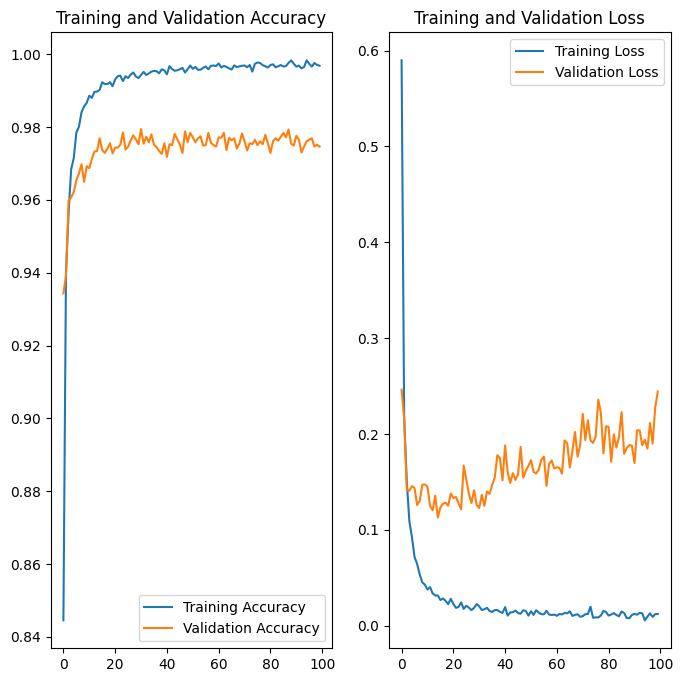

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.save('my_model') # Save trained model

# PROGRAM DIBAWAH INI DIGUNAKAN UNTUK MELAKUKAN PREDIKSI PLAT MOTOR

# program untuk mendeteksi digit dari plat nomor motor

In [10]:
def potongKarakter():
    imgs.clear()
    grayimg = cv2.cvtColor(croppedimg, cv2.COLOR_BGR2GRAY)
    hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
    blured  = cv2.GaussianBlur(hisimg, (29,29), 0)
    edged   = cv2.Canny(blured, 10, 120)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    dilate = cv2.dilate(edged, kernel, iterations=1)

    contours, _ = cv2.findContours(dilate, cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
    image_copy = croppedimg.copy()
    imgrec = croppedimg.copy()

    platno=[]
    index=0
    realPlatno=0
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        aspect_ratio = w/h
        luas = w*h

        if w > 120 and h>=150 and h <410 and aspect_ratio <= 0.7 :
            platno.append(index)
            cv2.drawContours(image_copy, contours, index, (0, 255, 0), 2)
    #         print(f'x: {x}, y: {y}, w: {w}, h: {h}')
            realPlatno+=1
        index += 1
    # print(f'detected candidate plat no: {len(platno)}')

    urutx = []
    for char in platno:
        x,y,w,h = cv2.boundingRect(contours[char])
        urutx.append(x)
    urutx = sorted(urutx)

    ## urutkan karakter plat nomor dari kiri ke kanan
    cropCharUrut=[]
    for ux in urutx:
        for char in platno :
            x,y,w,h = cv2.boundingRect(contours[char])
            if x == ux:
                cropCharUrut.append(char)
                break
    o = 0
    for c in cropCharUrut:
        x,y,w,h = cv2.boundingRect(contours[c])
        o=0
        for i in cropCharUrut:
            if c==i:
                continue
            x2,y2,w2,h2 = cv2.boundingRect(contours[i])

            if abs(x-x2) < 10:
                cropCharUrut.pop(o)
            o+=1
    # print(cropCharUrut)

    for c in cropCharUrut:
        x,y,w,h = cv2.boundingRect(contours[c])
        cv2.rectangle(imgrec, (x,y), (x+w,y+h), (0,0,255),2)

    imgHeight = 40
    imgWidth  = 40

    for char in cropCharUrut:
        x,y,w,h = cv2.boundingRect(contours[char])
        crop = grayimg[y: y+h, x:x+w]
        ret,thresh = cv2.threshold(crop,127,255,cv2.THRESH_BINARY)
        char_crop = cv2.resize(thresh, (imgWidth, imgHeight))
        imgs.append(char_crop)

    display(imgrec, "box plat no")


> fungsi dibawah ini digunakan untuk melakukan klasifikasi setiap karakter yang telah terpotong, prediksi yang didapatkan akan dimasukan ke dalam array dan ditampilkan pada gambar awal.

In [11]:
def cobaTebak():
    predictedPlat=[]
    predictedPlat.clear()
    for index in range(0, len(imgs)):
        image1 =cv2.adaptiveThreshold(np.array(imgs[index]), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
        char_crop = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)

        # resize citra karakternya
        char_crop = cv2.resize(char_crop, (imgWidth, imgHeight))
    #     display(char_crop)

        # preprocessing citra ke numpy array
        img_array = keras.preprocessing.image.img_to_array(char_crop)
        # agar shape menjadi [1, h, w, channels]
        img_array = tf.expand_dims(img_array, 0)

        pred = model.predict(img_array)
        score = tf.nn.softmax(pred[0])

    #     print(class_names[np.argmax(score)])
    #     ax.imshow(image)
        predictedPlat.append(class_names[np.argmax(score)])
#         print(predictedPlat)

    label=""
    label=label.join(predictedPlat)
    print(label)
    cv2.putText(image, label, org, cv2.FONT_HERSHEY_SIMPLEX, 10, (0,0,255), 15, cv2.LINE_AA)

    display(image)

TERDETEKSI 1 BUAH PLAT NOMOR


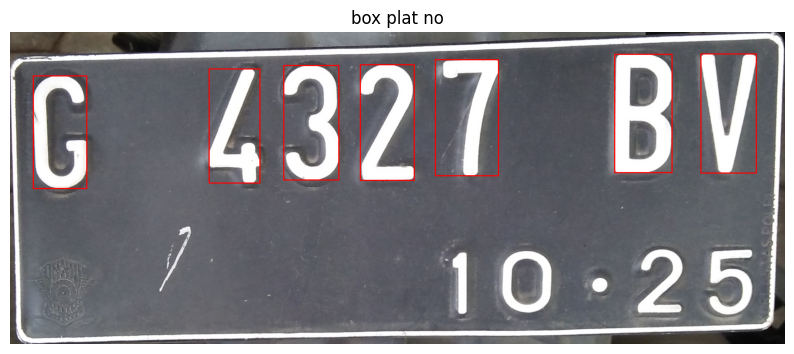

1/1 [==============================] - 0s 35ms/step
G4327BV


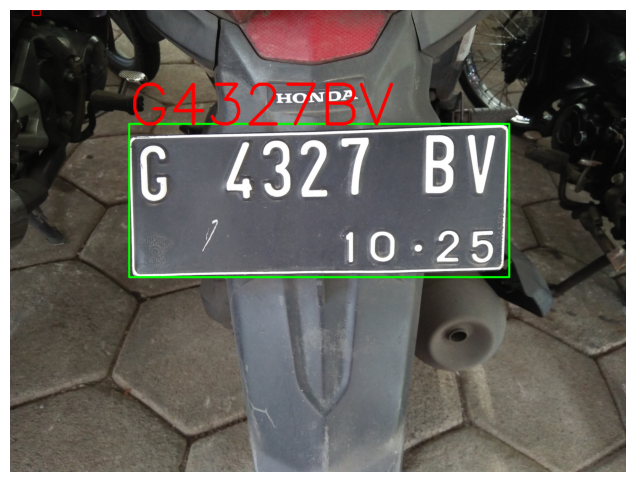

In [12]:
img = cv2.imread('/kaggle/input/haarcascadeplatenumber/dataset/G4327BV.jpg')
# img = cv2.imread('/input/haarcascadeplatenumber/dataset/AD3324IT.jpg')
model = keras.models.load_model('/content/my_model')

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# predictedPlat=[]

grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
blured  = cv2.GaussianBlur(hisimg, (21,21), 0)
edged   = cv2.Canny(blured, 10, 180)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
dilate = cv2.dilate(edged, kernel, iterations=1)

contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image_copy = img.copy()
cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 2)

platno=[]
index=0

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w/h

    if w > 560 and h>350 and h<1100 and aspect_ratio > 1.6 and aspect_ratio<=2.6:
#         print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')
        platno.append(index)
    index += 1
# print(f'detected plat no: {len(platno)}, index: {indeximg}')

imgs=[]
if len(platno)>0:
    print(f'TERDETEKSI {len(platno)} BUAH PLAT NOMOR')
    for plat in platno:
        image = cv2.rectangle(img.copy(), (x,y), (x+w,y+h), (0,0,255),3)
        detectedimg = img.copy()
        x,y,w,h = cv2.boundingRect(contours[plat])
        croppedimg = img[y: y+h, x:x+w]

        #buat gambar baru untuk menampilkan hasil
        image = cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0),10)
#         display(image)
        org = (x, y)
#         display(croppedimg)

        #lakukan pemtongan karakter plat nomor
        potongKarakter()

        #lakukan klasifikasi dari karakter yang didapatkan
        cobaTebak()

else:
    print("TIDAK TERDETEKSI PLAT NOMOR")


# program dibawah ini digunakan untuk menyimpan karakter yang sudah terpotong ke output directory

/kaggle/working/29_04_2024-10_26_5235f307f1-07a1-4d06-8a27-cc50c6e82f71.jpg


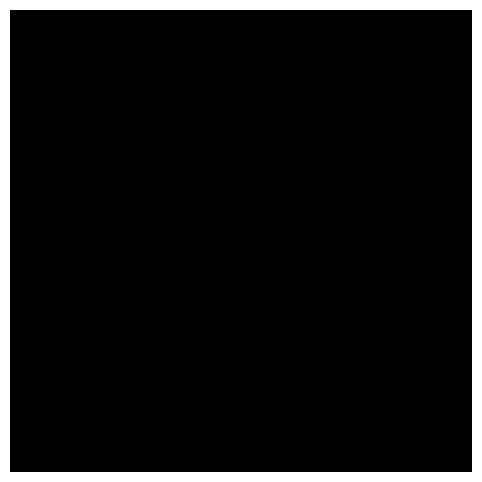

/kaggle/working/29_04_2024-10_26_5289ce616f-66c2-49dc-9475-8331cad86e84.jpg


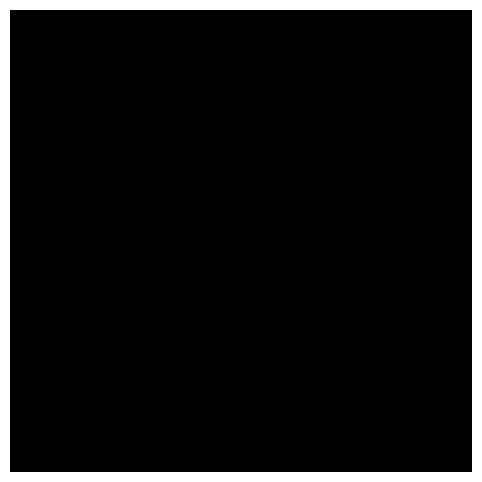

/kaggle/working/29_04_2024-10_26_5254ad240c-0595-4d1a-b218-62c3e3a022f4.jpg


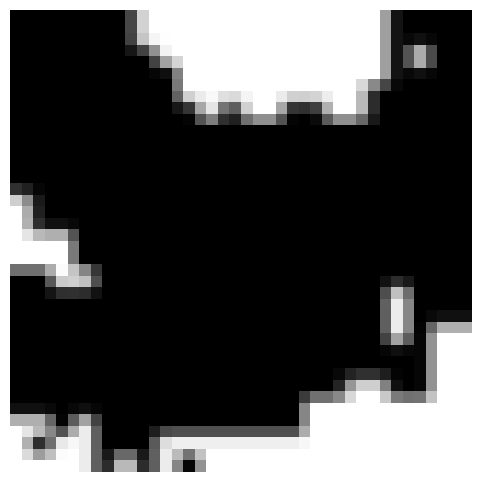

/kaggle/working/29_04_2024-10_26_520c9d7267-aa6c-4025-ae25-5dbfe3e84ab9.jpg


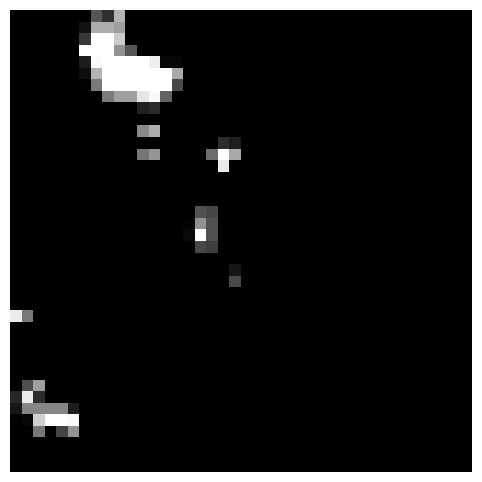

/kaggle/working/29_04_2024-10_26_529d246bbb-958e-431e-9a73-4658aa01c11b.jpg


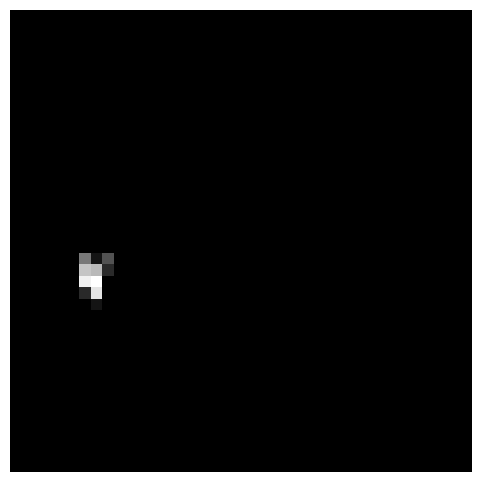

/kaggle/working/29_04_2024-10_26_52dcf89e91-54f9-417e-b99a-0c2d1014567f.jpg


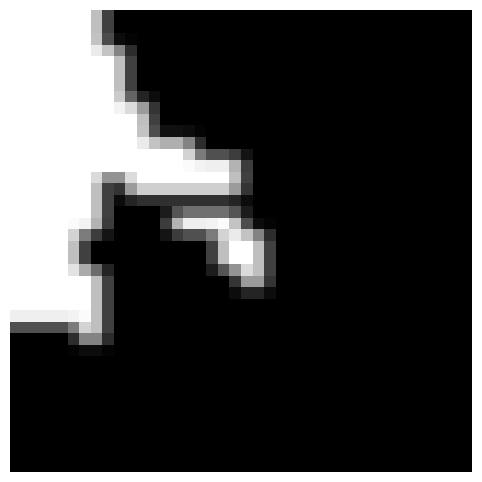

/kaggle/working/29_04_2024-10_26_525532ff31-c683-48e5-86c1-b8f16556de9f.jpg


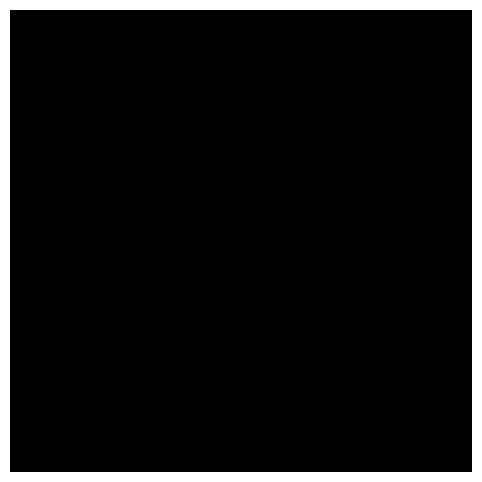

/kaggle/working/29_04_2024-10_26_5228eac931-b8fd-4aba-be97-7c80b51685d8.jpg


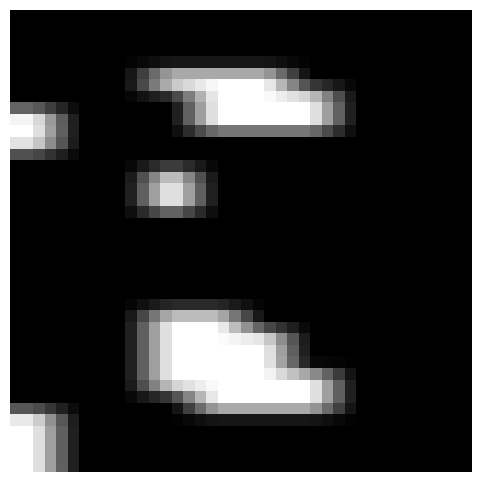

/kaggle/working/29_04_2024-10_26_52372a9444-76ef-48be-bfff-2673e8878425.jpg


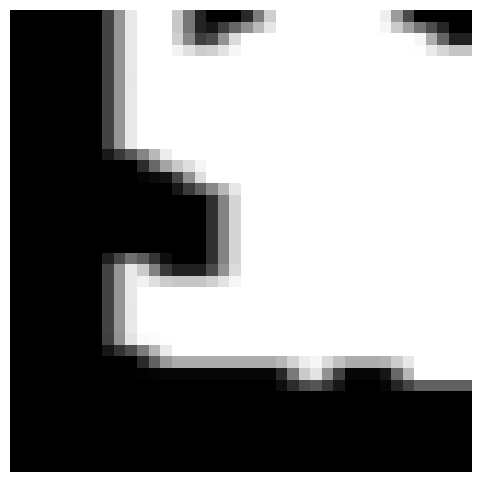

In [ ]:
from datetime import datetime
import uuid

# tampilkan karakter yang telah terpotong
imgs=[]
savepath='/kaggle/working/'
imgHeight = 40
imgWidth  = 40

for char in cropCharUrut:
    filename = str(datetime.now().strftime("%d_%m_%Y-%H_%M_%S")) + str(uuid.uuid4()) + ".jpg"
    filename = os.path.join(savepath, filename)
    print(filename)

    x,y,w,h = cv2.boundingRect(contours[char])
    crop = grayimg[y: y+h, x:x+w]
    ret,thresh = cv2.threshold(crop,127,255,cv2.THRESH_BINARY)
    char_crop = cv2.resize(thresh, (imgWidth, imgHeight))
    imgs.append(char_crop)
#     cv2.imwrite(filename, crop)
    display(char_crop)


1/1 [==============================] - 0s 21ms/step


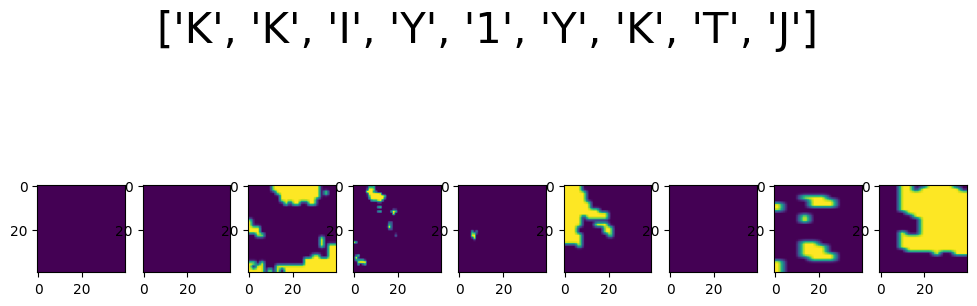

In [ ]:
# model = keras.models.load_model('/kaggle/working/my_model')

# display(imgs[index])
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
predictedPlat=[]


for index in range(0, len(imgs)):
    image =cv2.adaptiveThreshold(np.array(imgs[index]), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
    char_crop = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # resize citra karakternya
    char_crop = cv2.resize(char_crop, (imgWidth, imgHeight))
#     display(char_crop)

    # preprocessing citra ke numpy array
    img_array = keras.preprocessing.image.img_to_array(char_crop)
    # agar shape menjadi [1, h, w, channels]
    img_array = tf.expand_dims(img_array, 0)

    pred = model.predict(img_array)
    score = tf.nn.softmax(pred[0])

#     print(class_names[np.argmax(score)])
#     ax.imshow(image)
    predictedPlat.append(class_names[np.argmax(score)])

# image = cv2.putText(img.copy, 'OpenCV', org, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)

# plt.imshow(labeledImg)

_, axs = plt.subplots(1, len(cropCharUrut), figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.figtext(.5,.65,predictedPlat,fontsize=30,ha='center')
plt.show()

satu


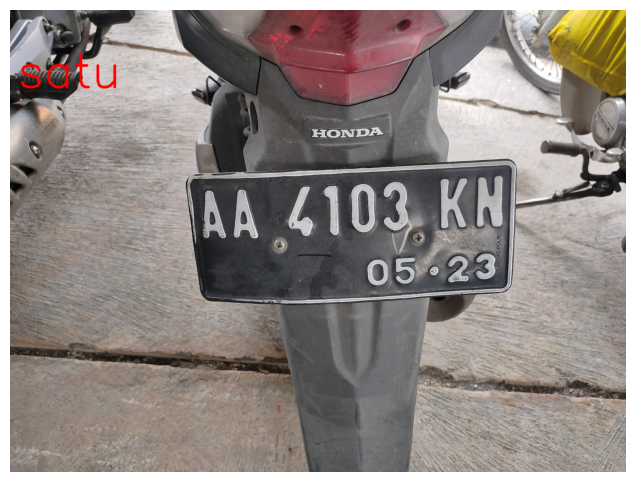

In [ ]:
img = cv2.imread('/kaggle/input/haarcascadeplatenumber/dataset/AA4103KN.jpg')

s = ['s', 'a', 't', 'u']
label = ""
label = label.join(s)
print(label)

image = cv2.putText(img, label, (50,500), cv2.FONT_HERSHEY_SIMPLEX, 10, (0,0,255), 15, cv2.LINE_AA)
display(image)